# 00 - Showcase pentapeptide: a PyEMMA walkthrough

This notebook is a reproduction of [PyEMMA tutorial](http://www.emma-project.org/v2.5.7/tutorials/notebooks/00-pentapeptide-showcase.html).
Overall, the notebook serves as an example workflow for analyzing molecular dynamics trajectories. The pentapeptide was simulated with implicit solvent and the trajectories were saved with a $0.1$ ns timestep.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings

## Data input and featurization [➜ 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/01-data-io-and-featurization.html)
### Loading data

We start our short walkthrough tutorial by loading a topology file (in this case, a PDB) and the trajectory data.

In [4]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

The above cell has downloaded the data from our servers;
in general, only strings of file paths need to be provided.

In [5]:
print(pdb)
print(files)

data/pentapeptide-impl-solv.pdb
['data/pentapeptide-00-500ns-impl-solv.xtc', 'data/pentapeptide-01-500ns-impl-solv.xtc', 'data/pentapeptide-02-500ns-impl-solv.xtc', 'data/pentapeptide-03-500ns-impl-solv.xtc', 'data/pentapeptide-04-500ns-impl-solv.xtc', 'data/pentapeptide-05-500ns-impl-solv.xtc', 'data/pentapeptide-06-500ns-impl-solv.xtc', 'data/pentapeptide-07-500ns-impl-solv.xtc', 'data/pentapeptide-08-500ns-impl-solv.xtc', 'data/pentapeptide-09-500ns-impl-solv.xtc', 'data/pentapeptide-10-500ns-impl-solv.xtc', 'data/pentapeptide-11-500ns-impl-solv.xtc', 'data/pentapeptide-12-500ns-impl-solv.xtc', 'data/pentapeptide-13-500ns-impl-solv.xtc', 'data/pentapeptide-14-500ns-impl-solv.xtc', 'data/pentapeptide-15-500ns-impl-solv.xtc', 'data/pentapeptide-16-500ns-impl-solv.xtc', 'data/pentapeptide-17-500ns-impl-solv.xtc', 'data/pentapeptide-18-500ns-impl-solv.xtc', 'data/pentapeptide-19-500ns-impl-solv.xtc', 'data/pentapeptide-20-500ns-impl-solv.xtc', 'data/pentapeptide-21-500ns-impl-solv.xtc',

As it is unknown which feature describes the system best, we start with a broad systematic analysis.
For the sake of simplicity, we are only interested in modeling the backbone kinetics.
Thus, we only consider features describing the backbone and not the side chains.

In PyEMMA, the `featurizer` is a central object that incorporates the system's topology.
Features are easily computed by adding the target feature, e.g.,
with `featurizer.add_backbone_torsions()`.
We will load backbone torsion angles, backbone heavy atom positions, and backbone heavy atom distances. 

⚠️ Please note that the structures have been aligned before.
Since in that case we loose track of the periodic box,
we have to switch off the `periodic` flag for the distance and torsion angle computations.

In [6]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/25 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/25 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/25 [00:00<?, ?it/s]

#### check data
torsions_data, position_data, and distances_data are lists of numpy array
- torsions_data: lists of 25 trajectories, each of (5001, 16) array shape  
- positions_data: lists of 25 trajectories, each of (5001, 45) array shape  
- distances_data: lists of 25 trajectories, each of (5001, 97) array shape  
    

In [7]:
#len(distances_data)

In [8]:
#distances_data[0].shape

### Feature selection
We will now rank the three featurizations by means of the VAMP2 score which measures the kinetic variance contained in these features <a id="ref-1" href="#cite-gmrq">mcgibbon-15</a>, <a id="ref-2" href="#cite-vamp-preprint">wu-17</a>, <a id="ref-3" href="#cite-vampnet">mardt-17</a>.
The minimum value of this score is $1$, which corresponds to the invariant measure or equilibrium.

As we are comparing featurizations with different dimensionality,
we use the dimension parameter to provide an upper bound for the number of dynamic processes included in the scoring.

In [9]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.
    
    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.
    
    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

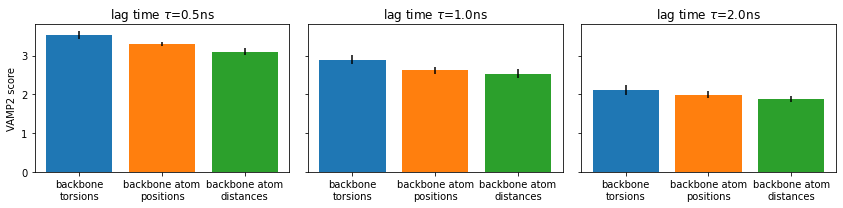

In [10]:
dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

⚠️ Please note that the VAMP-2 score is **not** suitable to select the proper lag time as scores for different lag times are not comparable.

Here, we just compare different features at each given lag time separately.
We consistently find backbone torsions to have a slight advantage.

Thus, we add a more detailed VAMP2 score analysis for backbone torsions by varying the dimension parameter for several lag times:

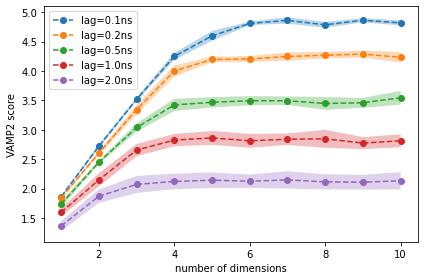

In [11]:
lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(torsions_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

We observe that, for lag times above 0.5 ns, using more than four dimensions does not increase the score, i.e.,
the first four dimensions contain all relevant information of the slow dynamics.

Based on this result, we try a TICA projection with lag time 0.5 ns (5 steps).
Please note that this is a modeler's choice based on the best heuristic that is currently available to our knowledge. 
It might be necessary to re-adjust the TICA lag time after the MSM estimation. 
uent stages, e.g.,
clustering, in order to avoid loading all transformed data into memory.

## Coordinate transform and discretization  [➜ 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/02-dimension-reduction-and-discretization.html)

### TICA

The goal of the next step is to find a function that maps the usually high-dimensional input space into some lower-dimensional space that captures the important dynamics.
The recommended way of doing so is a time-lagged independent component analysis (TICA), <a id="ref-4" href="#cite-tica2">molgedey-94</a>, <a id="ref-5" href="#cite-tica">perez-hernandez-13</a>.
We perform TICA (with kinetic map scaling) using the lag time obtained from the VAMP-2 score.

By using the tica() function's default parameters, we will use as many dimensions as necessary in order to preserve $95\%$ of the kinetic variance.
By default, tica() also applies a kinetic map scaling.
This scaling ensures that Euclidean distances in the projected space approximate kinetic distances,
which is beneficial during the subsequent discretization.

Please note that the general `PyEMMA` API is consistant for all estimators.
By calling the TICA estimator with the data (`tica = pyemma.coordinates.tica(torsions_data)`),
the estimation is done and an estimator instance returned (`tica`);
this object contains all the information about the specific transformation.
For small systems, we can access the transformed data by calling `tica.get_output()`.
For large systems, we recommend to pass the `tica` object itself into the subseq

In [13]:
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

calculate covariances:   0%|          | 0/25 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/25 [00:00<?, ?it/s]

⚠️ Please note that the above variable `tica_concatenated` is a concatenation of independent trajectories and as such **not suitable** for any kind of analysis which **evaluates transitions**.
We use this variable purely for visualization purposes which require concatenated data.
Throughout all notebooks, we will use the `_concatenated` postfix to denote data which is not safe to run a TICA or MSM estimation on.

We visualize the marginal and joint distributions of our TICA components by simple histograming:

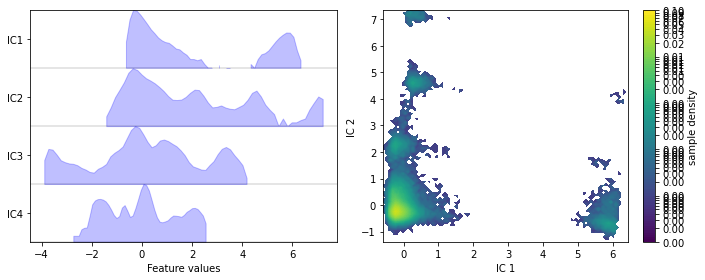

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

We note that the projection yields defined clusters of high density, which are most likely to be identified as metastable basins. 

Let’s have a look at one of the trajectories and what it looks like in the space of the first four TICA components.
We can see that the TICA components nicely resolve the slow transitions as discrete jumps.
Thus, metastability is well-described in this projection.

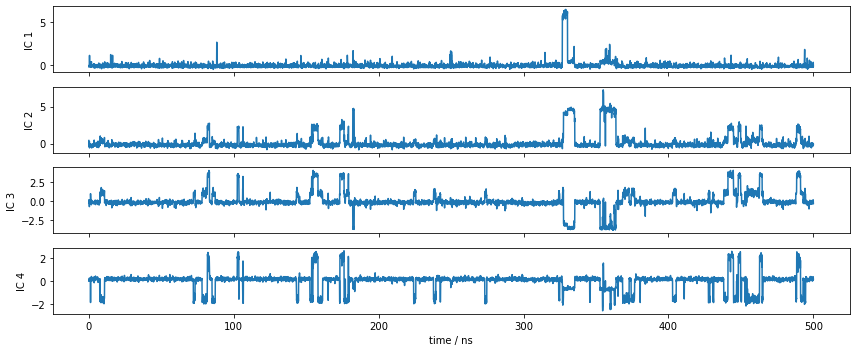

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

### Discretization

The TICA coordinates will now be clustered into a number of discrete states using the $k$-means algorithm.
The $k$-means algorithm requires as input the desired number of clusters.
The trajectories are automatically assigned to the cluster centers by calling `cluster.dtrajs`. 

⚠️ It is a priori unclear what the optimal number of cluster centers $k$ is.
It largely depends on the distribution of our data and on the number of dimensions we use.

In the following, we will estimate unvalidated Markov models using different numbers of cluster centers and use the VAMP-2 score (using cross validation) as a heuristic.
This approach requires us to guess the MSM lag time, which we set to the TICA lag time of $5$ steps (or $0.5$ ns).
Since the clustering algorithm is stochastic,
we conduct multiple rounds of discretization at each number of cluster centers.

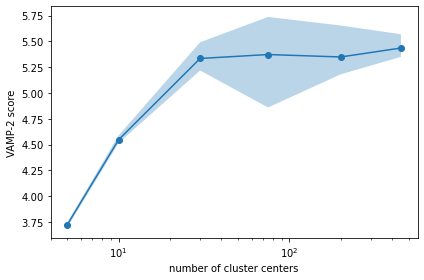

In [16]:
n_clustercenters = [5, 10, 30, 75, 200, 450]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

We find that the VAMP-2 score is already saturated at $75$ states.
We will use this number for further analysis.

As already stated above, the score has been generated using MSMs that were not validated,
meaning that the above plot is really just a heuristic.
Besides having an optimal score, we want to obtain a model that describes physically interesting states.
Thus, the number of states $k$ is often re-adjusted after model inspection.

In [17]:
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=75, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

initialize kmeans++ centers:   0%|          | 0/75 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/25 [00:00<?, ?it/s]

⚠️ Please note that $k$-means clustering is a stochastic procedure and,
hence, individual runs might yield different results.
In order to have reproducible results throughout the remainder of this notebook for each run,
we are fixing the random seed (not advised in general). 

We can check the location of our discrete states by plotting them onto the density of our data in the first two TICA dimensions.
The cluster centers are contained in the `cluster` object.

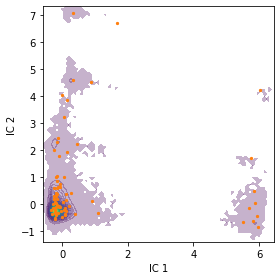

In [18]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

We note that the states are well distributed in the low-dimensional TICA subspace.

## MSM estimation and validation [➜ 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/03-msm-estimation-and-validation.html)
### Implied timescales

The first validation that is usually done when estimating a Markov model is the estimation of implied timescales (ITS) $t_i$.
They are computed from the eigenvalues $\lambda_i$ of the Markov transition matrix by

$$ t_i = \frac{-\tau}{\ln\left|\lambda_i(\tau)\right|} $$ 

with $\tau$ being the lag time.
The ITS $t_i$ approximates the decorrelation time of the $i$-th process;
the latter being independent of the model's hyper-parameter $\tau$.
Thus, we look for ITS convergence and choose $\tau$ accordingly, i.e.,
within a range where the ITS are approximately invariant.
Please note that the lag time also represents the time resolution limit of the estimated Markov model <a id="ref-6" href="#cite-msm-jhp">prinz-11</a>, <a id="ref-7" href="#cite-swope-its">swope-04</a>.

Now, we calculate the ITS with `pyemma.msm.its()` up to a lagtime of $50$ steps,
which is equivalent to $5$ ns for this dataset ($\Delta t=0.1$ ns).
The uncertainty of the implied timescales is quantified based upon Markov models sampled according to a Bayesian scheme.

⚠️ If this this is too time-consuming,
maximum likelihood MSMs can be used instead by setting the `errors` keyword argument to `None`.

Please note that, instead of a single number `lags=50`,
an array can be passed to compute the ITS at defined lag times.
When we pass an integer $K$ as this value,
a set of lag times starting from $\Delta t$ to $K\Delta t$ will be generated,
using a multiplier of $1.5$ between successive lag times.

estimating BayesianMSM:   0%|          | 0/10 [00:00<?, ?it/s]

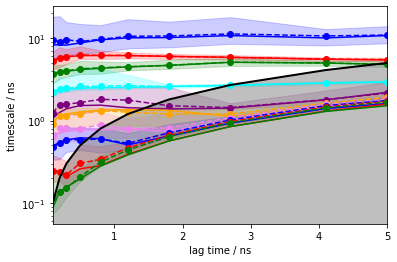

In [19]:
its = pyemma.msm.its(cluster.dtrajs, lags=50, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);

The solid lines correspond to the ITS of maximum likelihood MSMs.
The confidence intervals are depicted by the shaded areas;
they contain 95% of the samples generated by the Bayesian MSM.
The sample means are given by dashed lines.

The implied timescales converge quickly.
Above $0.5$ ns, the implied timescales of the slowest processes are constant within error.
We thus select a lag time of $5$ steps ($0.5$ ns) to build a Markov model.
As a quick check, we print the fraction of states and counts that are in the active set. 

Please note the similarity of the `msm` object to the `tica` object.
Both are estimator instances and contain all the relevant information from the estimation and methods for validation and further analysis. 

In order to keep track of our trajectory time step, a `dt_traj` keyword argument can be passed that contains the trajectory time step unit.

In [20]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[3671]: compute stat. inefficiencies:   0%|          | 0/3665 [0…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[3671]: Sampling MSMs:   0%|          | 0/100 [00:00<?, ?it/s]

fraction of states used = 1.00
fraction of counts used = 1.00


### Chapman-Kolmogorov test
The model is validated with a Chapman-Kolmogorov test. It compares the right and the left side of the Chapman-Kolmogorov equation

$$ \mathbf{P}(k \tau) = \mathbf{P}^k(\tau) $$

with $\mathbf{P}(\tau)$ being the transition matrix and lag time $\tau$.
PyEMMA automatically estimates a new MSM transition matrix at lag time $k \tau$ and propagates the original transition matrix by the $k$-th power.
The highest $k$ can be adjusted using the `mlags` keyword argument of `msm.cktest()`.

Since we can only inspect the result for a small number of (macro-) states,
we use the implied timescales plot as a heuristic to estimate a number of metastable states to test for. 
We can resolve $4$ slow processes up to lag times of $2.5$ ns.
Since the Chapman-Kolmogorov test involves estimations at higher lag times,
we will attempt to capture those processes choosing $5$ metastable states.

estimating BayesianMSM:   0%|          | 0/5 [00:00<?, ?it/s]

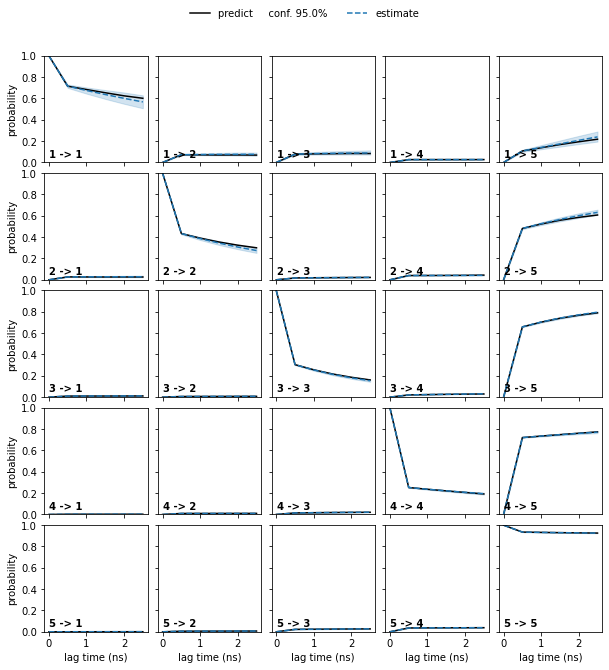

In [21]:
nstates = 5
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

Assuming $5$ metastable states in the data yields a passing Chapman-Kolmogorov test.

## MSM spectral analysis [➜ 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/04-msm-analysis.html)

From the MSM object `msm`, various properties can be obtained. We start the spectral analysis by examining the implied timescales.

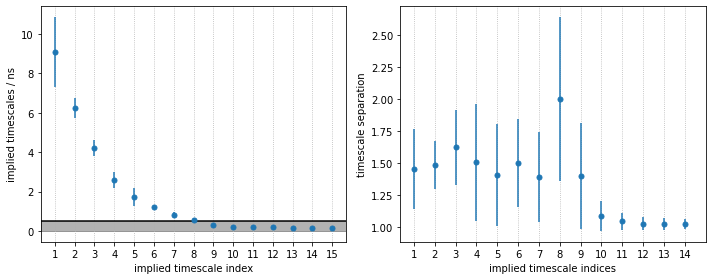

In [23]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt((ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)

nits = 15

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(range(1, nits + 1), timescales_mean, yerr=timescales_std, fmt='.', markersize=10)
axes[1].errorbar(range(1, nits), timescales_mean[:-1] / timescales_mean[1:], yerr=its_separation_err(timescales_mean, timescales_std), \
                 fmt='.', markersize=10, color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
#axes[1].set_xticklabels(["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)], rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')

fig.tight_layout()

As we see, PyEMMA sorts the implied timescales (and their corresponding eigenfunctions) in descending order.
From the timescale separation we can see that a comparably large timescale gap,
within the time resolution of the model, is between the 4th and 5th process,
suggesting that $5$ metastable states may be a good choice for coarse graining.
We discuss this further below.

We go on by analyzing the stationary distribution and the free energy computed over the first two TICA coordinates.
The stationary distribution, $\pi$, is stored in `msm.pi` or (as an alias) `msm.stationary_distribution`.
We compute the free energy landscape by re-weighting the trajectory frames with stationary probabilities from the MSM (returned by `msm.trajectory_weights()`).

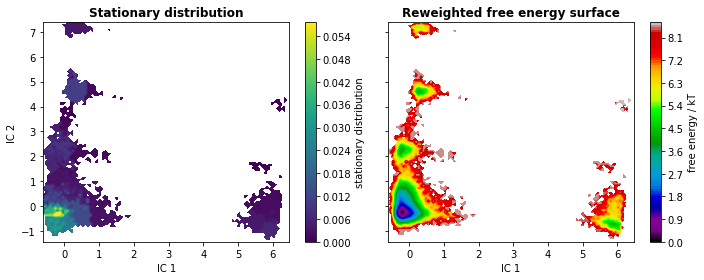

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, msm.pi[dtrajs_concatenated], ax=axes[0], mask=True, cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, weights=np.concatenate(msm.trajectory_weights()), ax=axes[1], legacy=False)

for ax in axes.flat:
    ax.set_xlabel('IC 1')

axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')

fig.tight_layout()

The eigenvectors corresponding to the slowest processes (largest implied timescales) contain information about what configurational changes are happening on which timescales.
We analyze the slowest processes by inspecting the value of the first four eigenfunctions projected on two the first TICA coordinates.
As the first right eigenvector corresponds to the stationary process (equilibrium), it is constant at $1$.

The first eigenvector is one: True (min=0.999999999999983, max=1.0000000000000033)


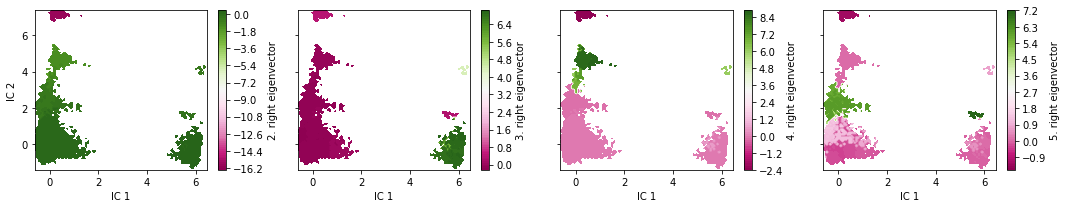

In [25]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, eigvec[dtrajs_concatenated, i + 1], ax=ax, \
                              cmap='PiYG', cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.set_xlabel('IC 1')

axes[0].set_ylabel('IC 2')
fig.tight_layout()

The eigenvectors of the MSM contain information about the conformational changes are happening,
governed by the correponding implied timescales.
Specifically, the minimum and maximum-valued components of an eigenvector indicate the states between a process shifts probability.
The relaxation timescale of this exchange process is exactly the implied timescale.

Since the eigenvectors were internally sorted according to their eigenvalue,
the above visualizations depict the four slowest processes of the implied timescale plot.
We see that, indeed, the slowest processes occur inbetween the dense clusters in the TICA projection.

## PCCA & TPT [➜ 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/05-pcca-tpt.html)

### Perron cluster cluster analysis

**Note:** We will assign the integer numbers $1 \dots $ `nstates` to PCCA++ metastable states. As PyEMMA is written in Python, it internally indexes states starting from $0$. In consequence, numbers in the code cells differ by $-1$ from the plot labels and markdown text. 

In [26]:
msm.pcca(nstates)

PCCA(P=array([[0.01535, 0.00042, ..., 0.02022, 0.00343],
       [0.00226, 0.16404, ..., 0.     , 0.     ],
       ...,
       [0.02271, 0.     , ..., 0.02   , 0.00408],
       [0.02266, 0.     , ..., 0.02399, 0.01067]]),
   m=5)

The PCCA++ algorithm computes so called memberships, i.e., the probability of each microstate to belong to a given macrostate.
In other words, PCCA++ does a fuzzy assignment of the microstates to macrostates which is encoded in the memberships.
We can visualize the $5$ membership distributions over the first $2$ TICA dimensions as follows:

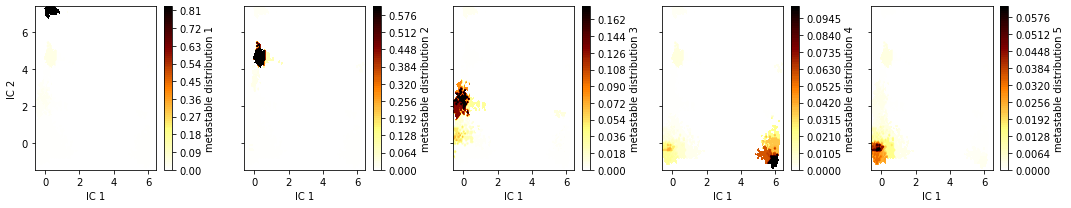

In [27]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, msm.metastable_distributions[i][dtrajs_concatenated], ax=ax, \
                              cmap='afmhot_r', mask=True, cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')

axes[0].set_ylabel('IC 2')
fig.tight_layout()

As we see, the membership probabilities roughly match to the basins of the free energy landscape presented above.

In some cases, it might be useful to convert these distributions into crisp assignments.
This can be computed by taking the argmax of each microstate's memberships to the macrostates.
They are contained in `msm.metastable_assignments`. Let's see what this looks like in the first two TICA projections.

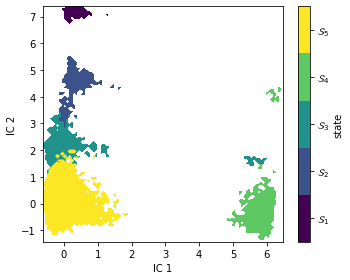

In [28]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(*tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
fig.tight_layout()

As expected, PCCA++ has nicely separated our state space within the first two TICA components.

At this point, we usually want to investigate which molecular structures the identified metastable structures correspond to.
We generate a number of representative sample structures for each macrostate and store them in a trajectory file for visual inspection.
The following cell writes trajectory files to hard disc. They can be loaded and analyzed with external software packages.

In [29]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
torsions_source = pyemma.coordinates.source(files, features=torsions_feat)
pyemma.coordinates.save_trajs(torsions_source, pcca_samples, outfiles=['./data/pcca{}_10samples.pdb'.format(n + 1) for n in range(msm.n_metastable)])

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

['./data/pcca1_10samples.pdb',
 './data/pcca2_10samples.pdb',
 './data/pcca3_10samples.pdb',
 './data/pcca4_10samples.pdb',
 './data/pcca5_10samples.pdb']

Alternatively, one can visualize the structures in this notebook with NGLView.
For this, we need to provide a custom function that defines the representations of our molecule:

In [30]:
def visualize_metastable(samples, cmap, selection='not element H'):
    """ visualize metastable states
    Parameters
    ----------
    samples: list of mdtraj.Trajectory objects
        each element contains all samples for one metastable state.
    cmap: matplotlib.colors.ListedColormap
        color map used to visualize metastable states before.
    selection: str
        which part of the molecule to selection for visualization. For details have a look here:
        http://mdtraj.org/latest/examples/atom-selection.html#Atom-Selection-Language
    """
    import nglview
    from matplotlib.colors import to_hex

    widget = nglview.NGLWidget()
    widget.clear_representations()
    ref = samples[0]
    for i, s in enumerate(samples):
        s = s.superpose(ref, atom_indices=s.top.select('resid 2 3 and mass > 2'))
        s = s.atom_slice(s.top.select(selection))
        comp = widget.add_trajectory(s)
        comp.add_licorice()

    # this has to be done in a separate loop for whatever reason...
    x = np.linspace(0, 1, num=len(samples))
    for i, x_ in enumerate(x):
        c = to_hex(cmap(x_))
        widget.update_licorice(color=c, component=i, repr_index=i)
        widget.remove_cartoon(component=i)
    return widget

Similar to saving the trajectories to disc, we now create a list with `mdtraj.Trajectory` objects that contain samples of our metastable structures. They are visualized with NGLView as follows:

In [ ]:
my_samples = [pyemma.coordinates.save_traj(files, idist, outfile=None, top=pdb)
              for idist in msm.sample_by_distributions(msm.metastable_distributions, 50)]

cmap = mpl.cm.get_cmap('viridis', nstates)
visualize_metastable(my_samples, cmap)

This coarse-grained representation of the dynamics is more directly amenable to human interpretation.
Nevertheless, as for the conventional MSM, we can still compute several interesting properties.
We start with the stationary distribution which encodes the free energy of the states.
This can be achieved by summing all the  contributions to a coarse-grained state $\mathcal{S}_i$:

$$ G_i = - \textrm{k}_\textrm{B} T \ln \sum_{j\in \mathcal{S}_i} \pi_j $$

In [31]:
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.003840	5.562302
2	0.013335	4.317400
3	0.022091	3.812563
4	0.021054	3.860686
5	0.939681	0.062215


Knowing PCCA++ metastable states, we can also extract mean first passage times (MFPTs) between them:

In [32]:
from itertools import product

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4,5
1,0.00,228.31,69.17,306.60,11.37
2,2205.62,0.00,113.15,295.71,5.09
3,2249.92,321.98,0.00,298.19,2.73
4,2306.07,324.50,116.38,0.00,6.63
5,2301.89,323.47,112.23,298.19,0.00


As it will become clear in further sections, metastable state $1$ could be distinguished from the other states by experiment.
We can extract the MFPT into (out of) this state from (into) any other state using the Bayesian sample as follows:

In [33]:
A = msm.metastable_sets[0]
B = np.concatenate(msm.metastable_sets[1:])
print('MFPT 1 -> other: ({:6.1f} ± {:5.1f}) ns'.format(msm.sample_mean('mfpt', A, B), msm.sample_std('mfpt', A, B)))
print('MFPT other -> 1: ({:.1f} ± {:5.1f}) ns'.format(msm.sample_mean('mfpt', B, A), msm.sample_std('mfpt', B, A)))

MFPT 1 -> other: (   8.8 ±   1.8) ns
MFPT other -> 1: (2297.3 ± 438.3) ns


The MFPT from state $1$ to any other state is very short compared to the other direction, i.e., this state has a comparably short lifetime. 

### Transition path theory

The flux between metastable states can be computed and coarse-grained as follows.
As an example, we compute the flux between metastable states $2$ and $4$.

In [34]:
start, final = 1, 3
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)

The committor as projected onto the first two TICA dimensions can be displayed with a filled contour plot:

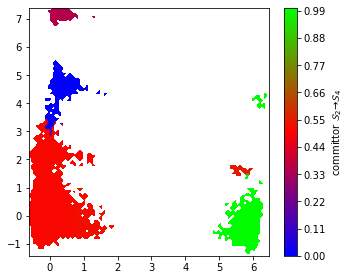

In [35]:
fig, ax = plt.subplots(figsize=(5, 4))
pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, flux.committor[dtrajs_concatenated], cmap='brg', ax=ax, \
                          mask=True, cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (start + 1, final + 1))
fig.tight_layout()

We find that the committor is constant within the metastable sets defined above.
Transition regions can be identified by committor values $\approx 0.5$.

## Computing experimental observables [➜ 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/06-expectations-and-observables.html)

Having thoroughly constructed, validated, and analyzed our MSM,
we may want to take the next step and compare our model to experimental data.
PyEMMA enables computation of stationary as well as dynamic experimental observables;
below we give give some examples of this.
We will make use of some external library functionality provided by MDTraj <a id="ref-9" href="#cite-mdtraj">mcgibbon-15</a>.

[Notebook 06](http://www.emma-project.org/v2.5.7/tutorials/notebooks/06-expectations-and-observables.html) includes a brief summary of the theory used in below.
More in-depth descriptions of the theory and their applications to various data can be found in the following references:
- <a id="ref-10" href="#cite-simon-amm">olsson-17</a>
- <a id="ref-11" href="#cite-noe-fingerprints">noe-11</a>
- <a id="ref-12" href="#cite-simon-mech-mod-nmr">olsson-16</a>
- <a id="ref-13" href="#cite-noe-dy-neut-scatt">lindner-13</a>

In [36]:
from mdtraj import shrake_rupley, compute_rg

#We compute a maximum likelihood MSM for comparison
mlmsm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=5, dt_traj='0.1 ns')

The way PyEMMA computes all experimental observables relies on us having a value of the observable for each of the Markov states in our MSM or frames in our trajectories.
Computing these quantities depends on the experiment in question and may require specific domain knowledege or involve time-consuming computations.
Here we will pre-compute these experimental observables in the following cells.

First, we sample $20$ representative configurations from each Markov state.
Note that $20$ representative configurations is not a universal number:
a specific observable of interest may require substantially more representative configurations to converge.

In [37]:
markov_samples = [smpl for smpl in msm.sample_by_state(20)]

reader = pyemma.coordinates.source(files, top=pdb)
samples = [pyemma.coordinates.save_traj(reader, smpl, outfile=None, top=pdb) for smpl in markov_samples]

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

Now we back-compute two experimental observables, the solvent accessible surface area (SASA) and the radius of gyration,
of each of the sampled configurations using MDTraj and average each of these observables over the Markov states.
Each of these averages corresponds to our Markov state proxy of the macroscopic experimental observable we want to predict.

In [38]:
# Compute solvent accessible surface area for all samples
markov_sasa_all = [shrake_rupley(sample, mode='residue') for sample in samples]

# Compute radius of gyration for all samples
markov_rg_all = [compute_rg(sample) for sample in samples]

# Average over Markov states for both observables.
markov_average_trp_sasa = np.array(markov_sasa_all).mean(axis=1)[:, 0]
markov_average_rg = np.array(markov_rg_all).mean(axis=1)

### Radius of gyration
The radius of gyration $r_g(x)$ is a measure of the over-all size of a molecule in a certain configuration $x$.
It is a quantity often extracted from light-scattering experiments.
In the context of proteins and nucleic acids these experiments often happen on bulk samples and the observable is therefore stationary and averaged by the Boltzmann distribution:

$$ R_{g, \mathrm{obs}} = \mathcal{Z}^{-1}\int_{\Omega} \mathrm{d}x\, r_g(x) \exp\left(-\frac{E(x)}{kT}\right). $$

This value is also called the _expectation value of $r^2_g(x)$ with respect to the Boltzmann distribution_.
Since we have access to the stationary distribution from the Markov model,
we can approximate this continuous integral by the sum:

$$ R_{g, \mathrm{obs}} \approx \sum_i \pi_i \mathbf{r_g}_i $$
with
$$ \mathbf{r_g}_i  = \frac{1}{\pi_i\mathcal{Z}} \int_{x\in S_i} \mathrm{d}x\, r_g(x)\exp\left(-\frac{E(x)}{kT}\right). $$

The last expression constitutes the average of the experimental observable $r_g(x)$ confined to each of our Markov states individually. 

Recall that we pre-computed the vector $\mathbf{r_g}=\{\mathbf{r_g}_i\}$ as `markov_average_rg` above.
Using this vector and our estimated Markov model,
we can compute the expectation value using the `expectation()` method.

In [39]:
print('The average radius of gyration of penta-peptide is'
      ' {:.3f} nm'.format(msm.expectation(markov_average_rg)))

The average radius of gyration of penta-peptide is 0.497 nm


Since we have a Bayesian MSM estimated,
we can also compute the uncertainty in our prediction of the observable as standard deviations or confidence intervals.
To achieve this, we use the methods `sample_std` and `sample_conf`:

In [41]:
print('The standard deviation of our prediction of the average radius of gyration'
      ' of pentapeptide is {:.9f} nm'.format(msm.sample_std('expectation', markov_average_rg)))

print('The {:d}% CI of our prediction of the average radius of gyration of'
      ' pentapeptide have the bounds ({:.5f}, {:.5f})'.format(int(msm.conf * 100), *msm.sample_conf('expectation', markov_average_rg)))

The standard deviation of our prediction of the average radius of gyration of pentapeptide is 0.000066737 nm
The 95% CI of our prediction of the average radius of gyration of pentapeptide have the bounds (0.49668, 0.49693)


So, our model is very confident in the prediction of the radius of gyration.
However, this does not guarantee it to be accurate &mdash; that is, agree with experimental measurements.
If we lack quantitative agreement with experiments,
we can estimate MSMs which optimally balance experimental data and simulation data using the Augmented Markov model (AMM) procedure.

### Trp-flourescene auto-correlation

Fluctuations in tryptophan flourescence can be measured using spectroscopic techniques.
These fluctuations depend, among other things,
on the solvent accessible surface area (SASA) of tryptophan residues.
Above, we pre-computed the SASA using the Shrake-Rupley algorithm which we show here projected onto the first two TICA dimensions:

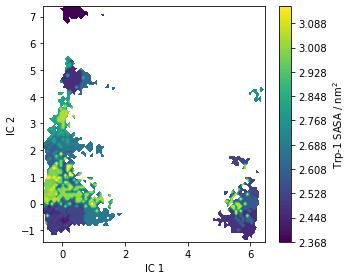

In [42]:
fig, ax = plt.subplots(figsize=(5, 4))
pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, markov_average_trp_sasa[dtrajs_concatenated], ax=ax, mask=True, cbar_label=r'Trp-1 SASA / nm$^2$')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

As for the stationary expectation (ensemble averages) considered above,
we can use our pre-computed SASA vector to compute the auto-correlation function of trypotophan flourescene using the MSM `correlation()` method (See [Notebook 06](http://www.emma-project.org/v2.5.7/tutorials/notebooks/06-expectations-and-observables.html#Dynamic/kinetic-experimental-observables) for details):

/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


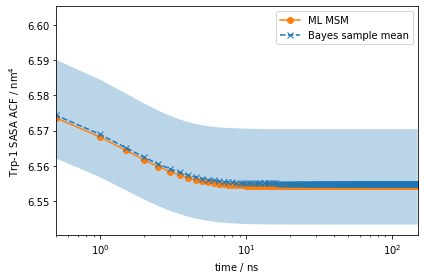

In [44]:
eq_time_ml, eq_acf_ml = mlmsm.correlation(markov_average_trp_sasa, maxtime=150)
eq_time_bayes, eq_acf_bayes = msm.sample_mean('correlation', np.array(markov_average_trp_sasa), maxtime=150)
eq_acf_bayes_ci_l, eq_acf_bayes_ci_u = msm.sample_conf('correlation', np.array(markov_average_trp_sasa), maxtime=150)

fig, ax = plt.subplots()
ax.plot(eq_time_ml, eq_acf_ml, '-o', color='C1', label='ML MSM')
ax.plot(eq_time_bayes, eq_acf_bayes, '--x', color='C0', label='Bayes sample mean')
ax.fill_between(eq_time_bayes, eq_acf_bayes_ci_l[1], eq_acf_bayes_ci_u[1], facecolor='C0', alpha=0.3)
ax.semilogx()
ax.set_xlim((eq_time_ml[1], eq_time_ml[-1]))
ax.set_xlabel(r'time / $\mathrm{ns}$')
ax.set_ylabel(r'Trp-1 SASA ACF / $\mathrm{nm}^4$')

ax.legend()
fig.tight_layout()

Note the scale on the $y$-axis: this amplitude is likely too small to be experimentally measurable considering experimental uncertainty.

However, using more advanced experimental setups such as stopped flow, T-jump, P-jump, and others,
we can prepare our ensemble in a non-equilibrium initial condition. (See [Notebook 06](http://www.emma-project.org/v2.5.7/tutorials/notebooks/06-expectations-and-observables.html#Dynamic/kinetic-experimental-observables) for details)

Let us say we can experimentally prepare a sample to only be in metastable state $\mathcal{S}_1$.
In this case, the initial condition will be given by the metastable distribution of metastable state $\mathcal{S}_1$, $p_0$.
With PyEMMA, we can simulate the relaxation from such a non-equilibrium initial condition $p_0$ back to equilibrium using the `relaxation()` method:

/Users/kt/anaconda3/envs/pyemma/lib/python3.8/site-packages/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


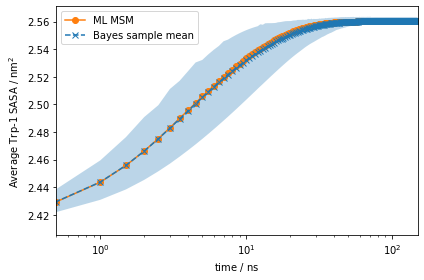

In [45]:
eq_time_ml, eq_relax_ml = mlmsm.relaxation(msm.metastable_distributions[0], markov_average_trp_sasa, maxtime=150)
eq_time_bayes, eq_relax_bayes = msm.sample_mean('relaxation', msm.metastable_distributions[0], np.array(markov_average_trp_sasa), maxtime=150)
eq_relax_bayes_CI_l, eq_relax_bayes_CI_u = msm.sample_conf('relaxation', msm.metastable_distributions[0], np.array(markov_average_trp_sasa), maxtime=150)

fig, ax = plt.subplots()
ax.plot(eq_time_ml, eq_relax_ml, '-o', color='C1', label='ML MSM')
ax.plot(eq_time_bayes, eq_relax_bayes, '--x', color='C0', label='Bayes sample mean')
ax.fill_between(eq_time_bayes, eq_relax_bayes_CI_l[1], eq_relax_bayes_CI_u[1], facecolor='C0', alpha=0.3)
ax.semilogx()

ax.set_xlim((eq_time_ml[1], eq_time_ml[-1]))
ax.set_xlabel(r'time / $\mathrm{ns}$')
ax.set_ylabel(r'Average Trp-1 SASA / $\mathrm{nm}^2$')

ax.legend()
fig.tight_layout()

This signal is much stronger than what we got from the auto-correlation at equilibrium above!

If we compute the average observable of each of our metastable states and compare them to the ensemble average,
we will get an idea of which initial distribution would give us the strongest signal.
We compare these values and report their absolute differences below:

In [46]:
state2ensemble = np.abs(msm.expectation(markov_average_trp_sasa) - msm.metastable_distributions.dot(np.array(markov_average_trp_sasa)))
DataFrame(np.round(state2ensemble, 3), index=range(1, nstates + 1), columns=[''])

,
1,0.147
2,0.005
3,0.287
4,0.018
5,0.008


Note how preparing our system in metastable state $\mathcal{S}_1$ will give us the strongest signal signified by the largest absolute difference between the observable in one metastable state to the global ensemble average.
However, note that there may be other initial conditions which may give us even stronger signals. 

Using methods such as the ones shown above,
we can imagine how to use MSMs to design experiments to aid validation and testing our model.

## Hidden Markov models [➜ 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/07-hidden-markov-state-models.html)

Another way of approaching metastable dynamics is with hidden Markov models (HMMs) <a id="ref-14" href="#cite-noe-proj-hid-msm">noe-15</a>.
HMMs model the dynamics between so-called hidden states which we initiate from the metastable states found by PCCA++.
The estimation is less prone to discretization errors as we do not assume Markovianity in the space of our cluster centers.
It further provides a natural coarse graining into a given number of hidden states,
thus yielding a means to generate a closed-form Markov model of the metastable dynamics.

In [Notebook 07 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/07-hidden-markov-state-models.html), after introducing HMMs,
you have the chance to estimate an HMM for the pentapeptide in the exercises section.

## Assembling manuscript figures

In the following, we use the results from this notebook to compile figures for the manuscript in this repository.
We start by setting new defaults which allow us to use the resulting figures without scaling in the manuscript.

In [47]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import LogLocator
from matplotlib.cm import get_cmap
from pyemma.plots.markovtests import _add_ck_subplot

mpl.rcParams['axes.titlesize'] = 6
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['xtick.labelsize'] = 5
mpl.rcParams['ytick.labelsize'] = 5
mpl.rcParams['xtick.minor.pad'] = 2
mpl.rcParams['xtick.major.pad'] = 3
mpl.rcParams['ytick.minor.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 3
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['lines.markersize'] = 4

This is Figure 3 (a,b,c,d) which sketches the system and coordinates part:

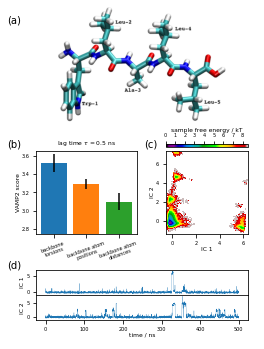

In [49]:
fig = plt.figure(figsize=(3.47, 4.65))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()
ax_box.text(0.00, 0.95, '(a)', size=10, zorder=1)
ax_box.text(0.00, 0.58, '(b)', size=10)
ax_box.text(0.55, 0.58, '(c)', size=10)
ax_box.text(0.00, 0.22, '(d)', size=10)

ax_mol = fig.add_subplot(gs[:1600, -2820:-400])
ax_mol.set_axis_off()
ax_mol.imshow(plt.imread('static/pentapeptide-structure.png'))

ax_feat = fig.add_subplot(gs[2000:3150, 400:1800])
ax_feat.bar(
    vamp_bars_plot['labels'],
    vamp_bars_plot['scores'],
    yerr=vamp_bars_plot['errors'],
    color=['C0', 'C1', 'C2'])
ax_feat.set_ylabel('VAMP2 score')
ax_feat.set_title(r'lag time $\tau$ = {:.1f} ns'.format(vamp_bars_plot['lag'] * 0.1))
ax_feat.set_ylim(2.75, 3.65)
ax_feat.tick_params(axis='x', labelrotation=20)

ax_sample_free_energy = fig.add_subplot(gs[2000:3150, 2200:3350])
_, _, misc = pyemma.plots.plot_free_energy(
    *tica_concatenated.T[:2],
    ax=ax_sample_free_energy,
    cax=fig.add_subplot(gs[1900:1950, 2200:3350]),
    cbar_orientation='horizontal',
    legacy=False)
misc['cbar'].set_label('sample free energy / kT')
misc['cbar'].set_ticks(np.arange(9))
misc['cbar'].ax.xaxis.set_ticks_position('top')
misc['cbar'].ax.xaxis.set_label_position('top')
ax_sample_free_energy.set_xlabel('IC 1')
ax_sample_free_energy.set_ylabel('IC 2')

x = 0.1 * np.arange(tica_output[0].shape[0])
ax_tic1 = fig.add_subplot(gs[3650:4000, 400:3350])
ax_tic2 = fig.add_subplot(gs[4000:4350, 400:3350])

ax_tic1.plot(x, tica_output[0][:, 0], linewidth=0.25)
ax_tic2.plot(x, tica_output[0][:, 1], linewidth=0.25)
ax_tic1.set_ylabel('IC 1')
ax_tic2.set_ylabel('IC 2')
ax_tic2.set_xlabel('time / ns')

fig.savefig('data/figure_3.pdf', dpi=300)

Next is Figure 4 (a,b) which shows estimation and validation:

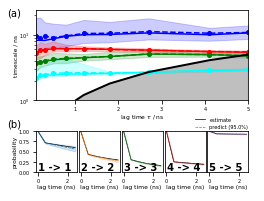

In [56]:
fig = plt.figure(figsize=(3.47, 2.60))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()
ax_box.text(0.00, 0.95, '(a)', size=10)
ax_box.text(0.00, 0.36, '(b)', size=10)

ax_its = fig.add_subplot(gs[50:1300, 400:3350])
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1, ax=ax_its, nits=4, ylog=True)
ax_its.set_ylim(1, ax_its.get_ylim()[1])
ax_its.set_xlabel(r'lag time $\tau$ / ns')

ax_ck = [
    fig.add_subplot(gs[1730:2300, 400:970]),
    fig.add_subplot(gs[1730:2300, 995:1565]),
    fig.add_subplot(gs[1730:2300, 1590:2160]),
    fig.add_subplot(gs[1730:2300, 2185:2755]),
    fig.add_subplot(gs[1730:2300, 2780:3350])]

for k, ax in enumerate(ax_ck):
    #lest, lpred = _add_ck_subplot(
    #    cktest, ax, k, k, ipos=cktest.nsets - 1, dt=0.1, units='ns', linewidth=0.7)
    lest, lpred = _add_ck_subplot(
        cktest, test_index=k, ax=ax, i=k, j=k, ipos=cktest.nsets - 1, dt=0.1, units='ns', linewidth=0.7)
    if k > 0:
        ax.set_yticks([])
predlabel = 'predict ({:3.1f}%)'.format(100.0 * cktest.conf)
estlabel = 'estimate'
ax_ck[-1].legend(
    (lest[0], lpred[0]),
    (estlabel, predlabel),
    frameon=False,
    loc='upper left',
    bbox_to_anchor=(-0.4, 1.45))

fig.savefig('data/figure_4.pdf', dpi=300)

Figure 5 (a,b,c,d) highlights the basic analysis part using map plots:

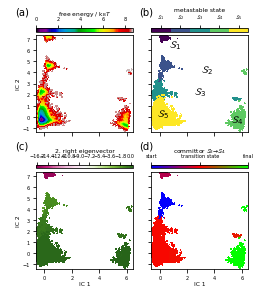

In [59]:
fig = plt.figure(figsize=(3.47, 3.95))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()
ax_box.text(0.03, 0.97, '(a)', size=10)
ax_box.text(0.53, 0.97, '(b)', size=10)
ax_box.text(0.03, 0.50, '(c)', size=10)
ax_box.text(0.53, 0.50, '(d)', size=10)

ax_fe = fig.add_subplot(gs[400:1750, 400:1750])
_, _, misc = pyemma.plots.plot_free_energy(
    *tica_concatenated.T[:2],
    weights=np.concatenate(msm.trajectory_weights()),
    ax=ax_fe,
    cax=fig.add_subplot(gs[300:350, 400:1750]),
    cbar_orientation='horizontal',
    legacy=False)
misc['cbar'].set_ticks(np.linspace(0, 8, 5))
misc['cbar'].ax.xaxis.set_ticks_position('top')
misc['cbar'].ax.xaxis.set_label_position('top')
misc['cbar'].set_label(r'free energy / $\mathrm{k}_\mathrm{B}T$')
ax_fe.set_ylabel('IC 2')
ax_fe.set_xticklabels([])

ax_state = fig.add_subplot(gs[400:1750, 2000:3350])
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated.T[:2],
    metastable_traj,
    ax=ax_state,
    cax=fig.add_subplot(gs[300:350, 2000:3350]),
    cbar_label='metastable state',
    cbar_orientation='horizontal')
misc['cbar'].ax.xaxis.set_ticks_position('top')
misc['cbar'].ax.xaxis.set_label_position('top')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
ax_state.set_xticklabels([])
ax_state.set_yticklabels([])
ax_state.text(0.70, 6.30, '$\mathcal{S}_1$', size=10)
ax_state.text(3.00, 4.00, '$\mathcal{S}_2$', size=10)
ax_state.text(2.50, 2.00, '$\mathcal{S}_3$', size=10)
ax_state.text(5.20, -0.50, '$\mathcal{S}_4$', size=10)
ax_state.text(-0.20, 0.00, '$\mathcal{S}_5$', size=10)

evec_idx = 1
ax_eig = fig.add_subplot(gs[2300:3650, 400:1750])
_, _, misc = pyemma.plots.plot_contour(
    *tica_concatenated.T[:2],
    eigvec[dtrajs_concatenated, evec_idx],
    cmap='PiYG',
    ax=ax_eig,
    mask=True,
    cax=fig.add_subplot(gs[2200:2250, 400:1750]),
    cbar_label='{}. right eigenvector'.format(evec_idx + 1),
    cbar_orientation='horizontal')
#misc['cbar'].set_ticks(np.linspace(*misc['cbar'].get_clim(), 3))
misc['cbar'].ax.xaxis.set_ticks_position('top')
misc['cbar'].ax.xaxis.set_label_position('top')
ax_eig.set_xlabel('IC 1')
ax_eig.set_ylabel('IC 2')

ax_flux = fig.add_subplot(gs[2300:3650, 2000:3350])
_, _, misc = pyemma.plots.plot_contour(
    *tica_concatenated.T[:2],
    flux.committor[dtrajs_concatenated],
    cmap='brg',
    ax=ax_flux,
    mask=True,
    cax=fig.add_subplot(gs[2200:2250, 2000:3350]),
    cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (
        start + 1, final + 1),
    cbar_orientation='horizontal')
misc['cbar'].set_ticks(np.linspace(0, 1, 3))
misc['cbar'].set_ticklabels(['start', 'transition state', 'final'])
misc['cbar'].ax.xaxis.set_ticks_position('top')
misc['cbar'].ax.xaxis.set_label_position('top')
ax_flux.set_xlabel('IC 1')
ax_flux.set_yticklabels([])

fig.savefig('data/figure_5.pdf', dpi=300)

Figure 6 visualizes the $\mathcal{S}_2\to\mathcal{S}_4$ committor:

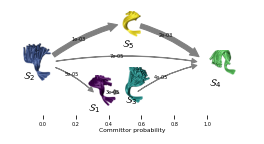

In [61]:
fig = plt.figure(figsize=(3.47, 1.804))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()

posx = cgflux.forward_committor
posy = 0.1 * np.array([4.5, 2.3, 2.3, 7, 4.5])
pos = np.vstack([posx, posy]).T

sizes = [[385, 432], [388, 526], [347, 500], [367, 348], [260, 374]]
anchors = [[1120, 950], [220, 500], [1630, 830], [2800, 600], [1600, 50]]
for i, ((w, h), (x, y)) in enumerate(zip(sizes, anchors)):
    ax_ = fig.add_subplot(gs[y:y+h, x:x+w])
    ax_.set_axis_off()
    ax_.text(0, 500, r'$\mathcal{S}_' + '{}$'.format(i + 1))
    ax_.imshow(plt.imread('static/hmm-backbone-{}-{}x{}.png'.format(i + 1, w, h)))

flux_ax = fig.add_subplot(gs[:1500, :])
pyemma.plots.plot_flux(
    cgflux,
    pos=pos,
    ax=flux_ax,
    state_sizes=np.array([1.5 for _ in range(len(cgflux.stationary_distribution))]),
    state_colors='None',
    max_width=15,
    max_height=15,
    minflux=2e-5,
    arrow_scale=1.,
    size=5,
    state_labels=None,
    show_committor=True)
flux_ax.set_xticks(np.arange(0, 1.2, .2))

fig.savefig('data/figure_6.pdf', dpi=300)

And, finally, Figure 7 (a,b) depicts the Trp-1 autocorrelation:

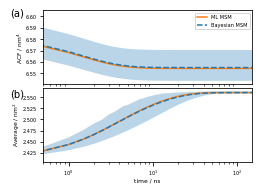

In [62]:
fig = plt.figure(figsize=(3.47, 2.5))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)

ax_box = fig.add_subplot(gs[:, :])
ax_box.set_axis_off()
ax_box.text(0.01, 0.95, '(a)', size=10)
ax_box.text(0.01, 0.50, '(b)', size=10)

ax_acf = fig.add_subplot(gs[50:1075, 500:3400])
ax_acf.plot(eq_time_ml, eq_acf_ml, '-', color='C1', label='ML MSM')
ax_acf.plot(
    eq_time_bayes,
    eq_acf_bayes,
    '--',
    color='C0',
    label='Bayesian MSM')
ax_acf.fill_between(
    eq_time_bayes,
    eq_acf_bayes_ci_l[1],
    eq_acf_bayes_ci_u[1],
    facecolor='C0',
    alpha=0.3)
ax_acf.semilogx()
ax_acf.set_xlim((eq_time_ml[1], eq_time_ml[-1]))
ax_acf.set_xticks([])
ax_acf.set_ylabel(r'ACF / nm$^4$')
ax_acf.legend()

ax_rlx = fig.add_subplot(gs[1125:2150, 500:3400])
ax_rlx.plot(eq_time_ml, eq_relax_ml, '-', color='C1', label='ML MSM')
ax_rlx.plot(
    eq_time_bayes,
    eq_relax_bayes,
    '--',
    color='C0',
    label='Bayesian MSM')
ax_rlx.fill_between(
    eq_time_bayes,
    eq_relax_bayes_CI_l[1],
    eq_relax_bayes_CI_u[1],
    facecolor='C0',
    alpha=0.3)
ax_rlx.semilogx()
ax_rlx.set_ylabel(r'Average / nm$^2$')
ax_rlx.set_xlim((eq_time_ml[1], eq_time_ml[-1]))
ax_rlx.set_xlabel(r'time / ns')

fig.savefig('data/figure_7.pdf', dpi=300)

## Wrapping up

In this notebook, we have illustrated how to conduct an MD analysis with Markov models using PyEMMA.
For the next steps, we recommend to work through the remaining eight notebooks, ideally in order,
to strengthen your understanding of the PyEMMA software.

1. [Data-I/O and featurization 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/01-data-io-and-featurization.html) 
2. [Dimension reduction and discretization 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/02-dimension-reduction-and-discretization.html) 
3. [MSM estimation and validation 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/03-msm-estimation-and-validation.html)
4. [MSM analysis 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/04-msm-analysis.html)
5. [PCCA and TPT analysis 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/05-pcca-tpt.html)
6. [Expectations and observables 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/06-expectations-and-observables.html)
7. [Hidden Markov state models (HMMs) 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/07-hidden-markov-state-models.html).
8. [Common problems & bad data situations 📓](http://www.emma-project.org/v2.5.7/tutorials/notebooks/08-common-problems.html)

## References

<a id="cite-gmrq"/><sup><a href=#ref-1>[^]</a></sup>Robert T. McGibbon and Vijay S. Pande. 2015. _Variational cross-validation of slow dynamical modes in molecular kinetics_. [URL](https://doi.org/10.1063/1.4916292)

<a id="cite-vamp-preprint"/><sup><a href=#ref-2>[^]</a></sup>Wu, H. and Noé, F.. 2017. _Variational approach for learning Markov processes from time series data_. [URL](https://arxiv.org/pdf/1707.04659.pdf)

<a id="cite-vampnet"/><sup><a href=#ref-3>[^]</a></sup>Andreas Mardt and Luca Pasquali and Hao Wu and Frank Noé. 2018. _VAMPnets for deep learning of molecular kinetics_. [URL](https://doi.org/10.1038/s41467-017-02388-1)

<a id="cite-tica2"/><sup><a href=#ref-4>[^]</a></sup>Molgedey, L. and Schuster, H. G.. 1994. _Separation of a mixture of independent signals using time delayed correlations_. [URL](http://dx.doi.org/10.1103/PhysRevLett.72.3634)

<a id="cite-tica"/><sup><a href=#ref-5>[^]</a></sup>Guillermo Pérez-Hernández and Fabian Paul and Toni Giorgino and Gianni De Fabritiis and Frank Noé. 2013. _Identification of slow molecular order parameters for Markov model construction_. [URL](https://doi.org/10.1063/1.4811489)

<a id="cite-msm-jhp"/><sup><a href=#ref-6>[^]</a></sup>Prinz, Jan-Hendrik and Wu, Hao and Sarich, Marco and Keller, Bettina and Senne, Martin and Held, Martin and Chodera, John D. and Schütte, Christof and Noé, Frank. 2011. _Markov models of molecular kinetics: Generation and validation_. [URL](http://scitation.aip.org/content/aip/journal/jcp/134/17/10.1063/1.3565032)

<a id="cite-swope-its"/><sup><a href=#ref-7>[^]</a></sup>William C. Swope and Jed W. Pitera and Frank Suits. 2004. _Describing Protein Folding Kinetics by Molecular Dynamics Simulations. 1. Theory\textdagger_. [URL](https://doi.org/10.1021/jp037421y)

<a id="cite-pcca_plus_plus"/><sup><a href=#ref-8>[^]</a></sup>Susanna Röblitz and Marcus Weber. 2013. _Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification_. [URL](https://doi.org/10.1007/s11634-013-0134-6)

<a id="cite-mdtraj"/><sup><a href=#ref-9>[^]</a></sup>McGibbon, Robert T. and Beauchamp, Kyle A. and Harrigan, Matthew P. and Klein, Christoph and Swails, Jason M. and Hernández, Carlos X. and Schwantes, Christian R. and Wang, Lee-Ping and Lane, Thomas J. and Pande, Vijay S.. 2015. _MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories_.

<a id="cite-simon-amm"/><sup><a href=#ref-10>[^]</a></sup>Simon Olsson and Hao Wu and Fabian Paul and Cecilia Clementi and Frank Noé. 2017. _Combining experimental and simulation data of molecular processes via augmented Markov models_. [URL](https://doi.org/10.1073/pnas.1704803114)

<a id="cite-noe-fingerprints"/><sup><a href=#ref-11>[^]</a></sup>F. Noe and S. Doose and I. Daidone and M. Lollmann and M. Sauer and J. D. Chodera and J. C. Smith. 2011. _Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments_. [URL](https://doi.org/10.1073/pnas.1004646108)

<a id="cite-simon-mech-mod-nmr"/><sup><a href=#ref-12>[^]</a></sup>Simon Olsson and Frank Noé. 2016. _Mechanistic Models of Chemical Exchange Induced Relaxation in Protein NMR_. [URL](https://doi.org/10.1021/jacs.6b09460)

<a id="cite-noe-dy-neut-scatt"/><sup><a href=#ref-13>[^]</a></sup>Benjamin Lindner and Zheng Yi and Jan-Hendrik Prinz and Jeremy C. Smith and Frank Noé. 2013. _Dynamic neutron scattering from conformational dynamics. I. Theory and Markov models_. [URL](https://doi.org/10.1063/1.4824070)

<a id="cite-noe-proj-hid-msm"/><sup><a href=#ref-14>[^]</a></sup>Frank Noé and Hao Wu and Jan-Hendrik Prinz and Nuria Plattner. 2013. _Projected and hidden Markov models for calculating kinetics and metastable states of complex molecules_. [URL](https://doi.org/10.1063/1.4828816)

